In [1]:
%matplotlib widget
%matplotlib inline
import sys
from sys import platform
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import ScalarFormatter
import numpy as np
import pickle
import seaborn as sns
import scipy
import emcee
import corner
import IPython
from IPython.display import display, Math
from tqdm import tqdm
from multiprocessing import Pool

from astropy.io import fits, ascii
from astropy.table import Table
from astropy.modeling import functional_models, fitting

import stingray.events as ev
import stingray.lightcurve as lc
from stingray import io
import stingray.powerspectrum as powspec 
import stingray.crossspectrum as crossspec
from hendrics.efsearch import dyn_folding_search, z_n_search, folding_search
import stingray.gti as sting_gti
import stingray.pulse.pulsar as plsr
from stingray import stats


sns.set_context('talk')
# sns.set_style("whitegrid")
sns.set_palette("colorblind")

sys.path.insert(1, '/Users/sean/scripts/helpers')

from stingray_plus import *

def minimize_remainder(arr, min_div, max_div):
    divisors = np.linspace(min_div, max_div, num=100)
    remainders = []
    for div in divisors:
        remainders.append(np.sum(np.mod(arr, div)))
        
    return divisors[np.argmin(remainders)]



# 2020

In [2]:
if platform=='linux' or platform=='linux2':
    print('Working on SRL server')
    root_dir = '/disk/lif2/spike/J1739m285/nustar/2020/'
elif platform=='darwin':
    print('Working on Macbook')
    root_dir='/Volumes/Samsung_1TB/AstroData/J1739m285/nustar/2020/'

timing_dir = root_dir + 'timing_products/'
products_dir = root_dir + 'products_3to78keV/'
plot_dir = root_dir + 'figures/'

OBSID = '90601307002'
    

Working on Macbook


In [3]:
burst1_gti = list(fits.open(root_dir + 'burst1/' + 'burst1_gti.fits')[1].data)
burst2_gti = list(fits.open(root_dir + 'burst2/' + 'burst2_gti.fits')[1].data)

burst_gti = [*burst1_gti, *burst2_gti]

persistent_gti = list(fits.open(root_dir + 'persistent_gti.fits')[1].data)

pre_burst1_gti = [[burst1_gti[0][0] - 10000, burst1_gti[0][0]]]
pre_burst2_gti = [[burst2_gti[0][0] - 10000, burst2_gti[0][0]]]

print(burst1_gti)
print(burst2_gti)
print(burst_gti)
print(persistent_gti)
print(pre_burst1_gti)
print(pre_burst2_gti)

[(319824471.2888854, 319824516.4585162)]
[(319838207.6183461, 319838246.4598603)]
[(319824471.2888854, 319824516.4585162), (319838207.6183461, 319838246.4598603)]
[(319800314.39138, 319824371.2888854), (319825016.4585162, 319838107.6183461), (319838746.4598603, 319861638.89138)]
[[319814471.2888854, 319824471.2888854]]
[[319828207.6183461, 319838207.6183461]]


/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:375: RuntimeWarning: underflow encountered in exp
  (c * ydiff ** 2)))
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:399: RuntimeWarning: underflow encountered in exp
  (c * ydiff2)))
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:409: RuntimeWarning: underflow encountered in true_divide
  dg_dA = g / amplitude
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:410: RuntimeWarning: underflow encountered in multiply
  dg_dx_mean = g * ((2. * a * xdiff) + (b * ydiff))
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:411: RuntimeWarning: underflow encountered in multiply
  dg_dy_mean = g * ((b * xdiff) + (2. * c * ydiff))
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:414: RuntimeWarning: underflow encountered i

Text(0, 0.5, 'NuSTAR count rate')

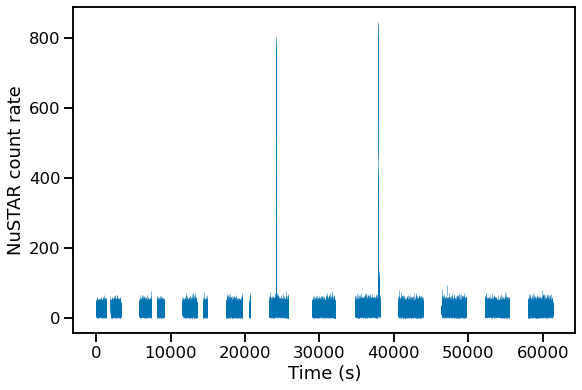

In [4]:
PI_min = 35     # 3.0 keV
# PI_min = 260     # 12.0 keV
PI_max = 960   # 40.0 keV
# PI_max = 1909   # 78.0 keV

centroid_A = [523.42071,455.48849]
centroid_B = [516.70582,454.38003]
extraction_radius = 46.783962

events = extract_events(timing_dir + 'nu' + OBSID + 'A01_cl_barycorr.evt', \
            timing_dir + 'nu' + OBSID + 'B01_cl_barycorr.evt')
events[0].set_xy_weights(centroid=centroid_A)
events[1].set_xy_weights(centroid=centroid_B)
# joined_events = events[0].join(events[1])
# print(events[0].time)

hk_files = [fits.open(timing_dir + 'nu' + OBSID + 'A_fpm_bc.hk'), fits.open(timing_dir + 'nu' + OBSID + 'B_fpm_bc.hk')]
hk_data_A = hk_files[0][1].data

plt.ion()

curveA = bkg_subtract(nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'A01_sr.lc'), nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'A01_bk.lc'))
curveB = bkg_subtract(nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'B01_sr.lc'), nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'B01_bk.lc'))
curve_total = sum_lc(curveA, curveB)
curve_10s = curve_total.rebin(dt_new=10)

t_start = np.min(curve_total.time)

plt.figure(figsize = (9,6))
plt.errorbar(curve_total.time-t_start, curve_total.countrate, xerr=curve_total.dt/2., yerr=curve_total.countrate_err, fmt='none', lw = 0.5)
plt.xlabel('Time (s)')
plt.ylabel('NuSTAR count rate')
# plt.close()





0


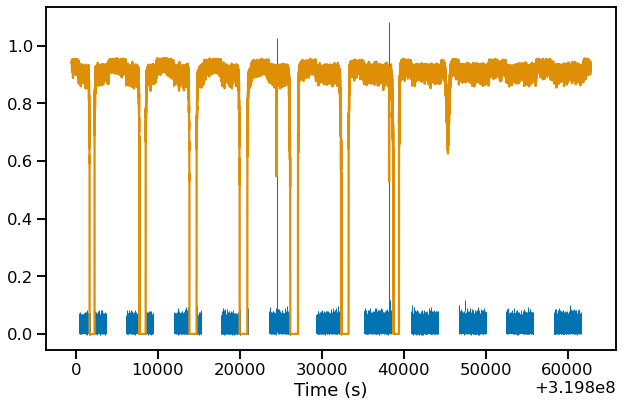

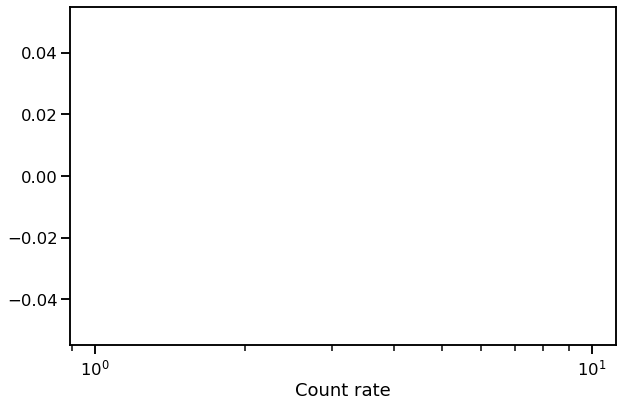

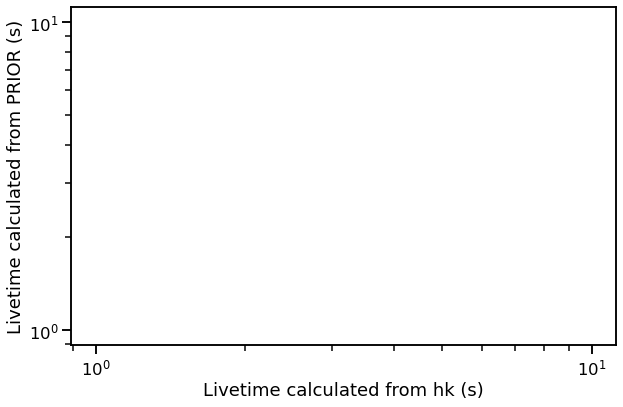

In [5]:
plt.figure(figsize=(9,6))
plt.errorbar(curve_total.time, curve_total.countrate/np.max(curve_total.countrate), xerr = curve_total.dt/2, yerr=curve_total.countrate_err/np.max(curve_total.countrate), fmt='none', lw=1.0)
plt.step(hk_data_A['TIME'], hk_data_A['LIVETIME'], where='mid')
plt.xlabel('Time (s)')
# plt.ylabel('Count rate')
plt.tight_layout()

livetime_prior = []
livetime_hk = []
livetime_rate = []
livetime_time = []

for i in range(len(curve_total.time)-5):
    if (curve_total.time[i+4] - curve_total.time[i] < 4.1) and (not i%5):
        hk_mask = (hk_data_A['TIME'] > curve_total.time[i]-0.1) * (hk_data_A['TIME'] < curve_total.time[i+5] + 0.1)
        if np.sum(hk_mask) == 5:
#             print('hk mask length: ' + str(np.sum(hk_mask)))
            ev_mask = (events[0].time > hk_data_A['TIME'][hk_mask][0]) * (events[0].time < (hk_data_A['TIME'][hk_mask][-1] + 1.0))

            livetime_time.append(np.mean(hk_data_A['TIME'][hk_mask] + 0.5))
            livetime_rate.append(np.mean(curve_total.countrate[i:i+5]))
            livetime_hk.append(np.sum(hk_data_A['LIVETIME'][hk_mask]))
            prior_temp = 0.0

            if np.sum(ev_mask) > 0:
                prior_temp += np.min([events[0].prior[ev_mask][0], events[0].time[ev_mask][0] -  hk_data_A['TIME'][hk_mask][0]])
                if np.sum(ev_mask) > 1:
                    prior_temp += np.sum(events[0].prior[ev_mask][1:])

                if events[0].time[ev_mask][0] - events[0].prior[ev_mask][0] < hk_data_A['TIME'][hk_mask][0]:
                    if livetime_time[-1] - livetime_time[-2] < 6.0:
                        livetime_prior[-1] += events[0].prior[ev_mask][0] - (events[0].time[ev_mask][0] - hk_data_A['TIME'][hk_mask][0])
            livetime_prior.append(prior_temp)
        
print(len(livetime_prior))
livetime_time = np.array(livetime_time)
livetime_rate = np.array(livetime_rate)
livetime_hk = np.array(livetime_hk)
livetime_prior = np.array(livetime_prior)

plt.figure(figsize=(9,6))
plt.scatter(livetime_rate, livetime_prior/livetime_hk)
plt.xlabel('Count rate')
plt.xscale('log')
# plt.ylabel('Count rate')
plt.tight_layout()

plt.figure(figsize=(9,6))
plt.scatter(livetime_hk, livetime_prior)
plt.xlabel('Livetime calculated from hk (s)')
plt.ylabel('Livetime calculated from PRIOR (s)')
plt.loglog()
# plt.ylabel('Count rate')
plt.tight_layout()



/Users/sean/scripts/helpers/stingray_plus.py:153: RuntimeWarning: underflow encountered in true_divide
  z_stat = plsr.z_n(fold_phases, n=2, norm=weights * p_weights * np.max(livetime_profile)/fold_lts)


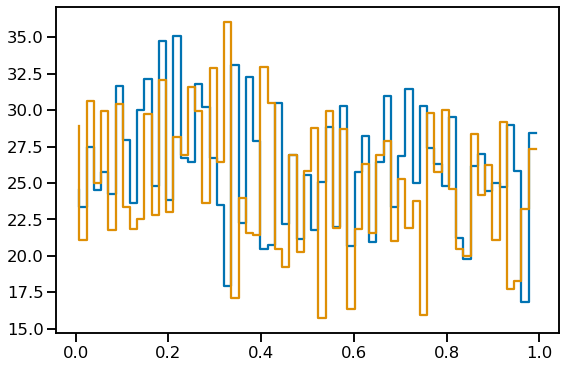

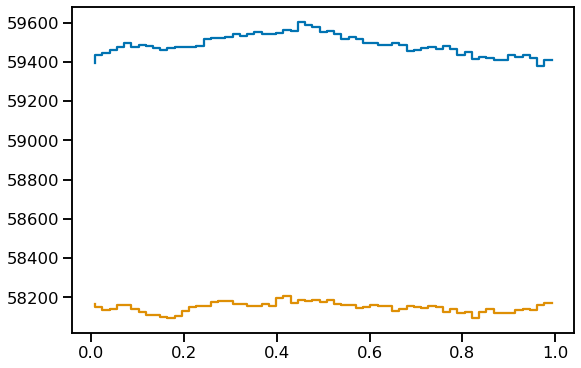

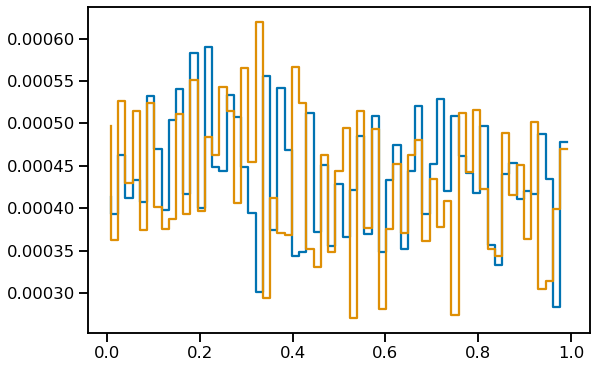

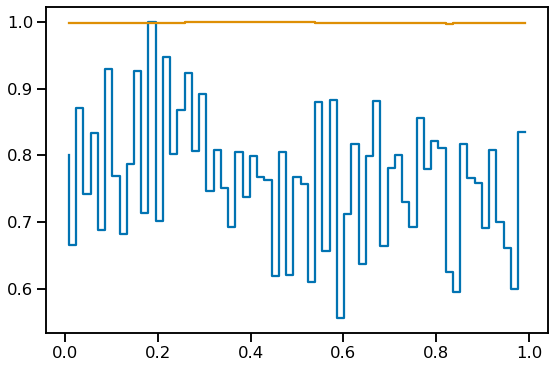

In [9]:
phase_bins_A, profile_A, profile_err_A, livetime_profile_A, z_stat_A = \
        events[0].fold_events_ltcorr(1124., time_intervals = burst_gti, \
                                nbin = 64, ref_time = events[0].time[0], region_filter=False, pi_min = 35, pi_max = 260, weight_pos=True)
phase_bins_B, profile_B, profile_err_B, livetime_profile_B, z_stat_B = \
        events[1].fold_events_ltcorr(1124., time_intervals = burst_gti, \
                                nbin = 64, ref_time = events[0].time[0], region_filter=False, pi_min = 35, pi_max = 260, weight_pos=True)


plt.figure(figsize=(9,6))
plt.step(phase_bins_A, profile_A)
plt.step(phase_bins_B, profile_B)

plt.figure(figsize=(9,6))
plt.step(phase_bins_A, livetime_profile_A)
plt.step(phase_bins_B, livetime_profile_B)

plt.figure(figsize=(9,6))
plt.step(phase_bins_A, profile_A/livetime_profile_A)
plt.step(phase_bins_B, profile_B/livetime_profile_B)

plt.figure(figsize=(9,6))
plt.step(phase_bins_A, (profile_A + profile_B)/(livetime_profile_A + livetime_profile_B)/np.max((profile_A + profile_B)/(livetime_profile_A + livetime_profile_B)))
plt.step(phase_bins_A, (livetime_profile_A + livetime_profile_B)/np.max(livetime_profile_A + livetime_profile_B))

# plt.figure(figsize=(9,6))
# plt.step(phase_bins_A, (profile_A/livetime_profile_A) + (profile_B/livetime_profile_B))



  0%|          | 0/1000 [00:00<?, ?it/s]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/stats.py:86: RuntimeWarning: underflow encountered in _logp_multitrial_from_single_logp
  np.log10(p1).astype(np.double), n)
100%|██████████| 1000/1000 [01:57<00:00,  8.51it/s]


0.17647997386064884218
1121.7947947947948
0.313229128343422758
1122.2852852852852
0.313229128343422758
1122.2852852852852


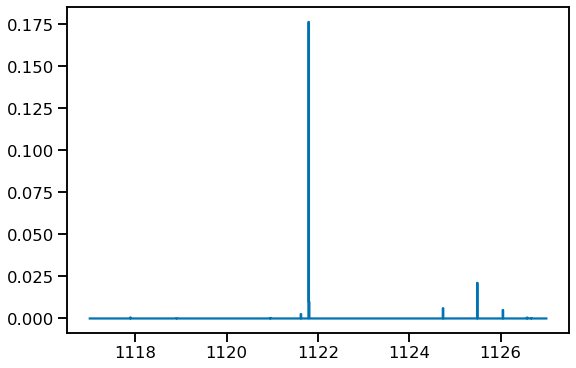

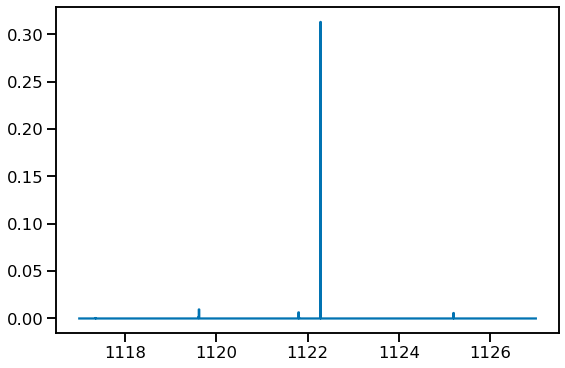

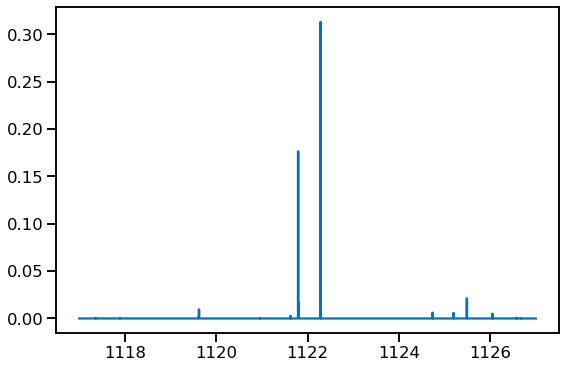

In [7]:
f_arr_A, z_prob_A = efold_search(events[0], f_min=1117., f_max=1127., f_steps=1000, time_intervals = burst1_gti, nbin = 32, pi_min = 35, pi_max = 260)
f_arr_B, z_prob_B = efold_search(events[1], f_min=1117., f_max=1127., f_steps=1000, time_intervals = burst1_gti, nbin = 32, pi_min = 35, pi_max = 260)
    
plt.figure(figsize= (9,6))
plt.step(f_arr_A, z_prob_A, where='mid')
print(np.max(z_prob_A))
print(f_arr_A[np.argmax(z_prob_A)])

plt.figure(figsize= (9,6))
plt.step(f_arr_B, z_prob_B, where='mid')
print(np.max(z_prob_B))
print(f_arr_B[np.argmax(z_prob_B)])

total_prob = z_prob_A + z_prob_B - (z_prob_A * z_prob_B)
plt.figure(figsize= (9,6))
plt.step(f_arr_A, total_prob, where='mid')
print(np.max(total_prob))
print(f_arr_A[np.argmax(total_prob)])    

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/stats.py:86: RuntimeWarning: underflow encountered in _logp_multitrial_from_single_logp
  np.log10(p1).astype(np.double), n)
100%|██████████| 1000/1000 [01:44<00:00,  9.57it/s]


0.301327427216198096
1121.6646646646648
0.38688482573883453686
1118.5215215215214
0.38688482573883453686
1118.5215215215214


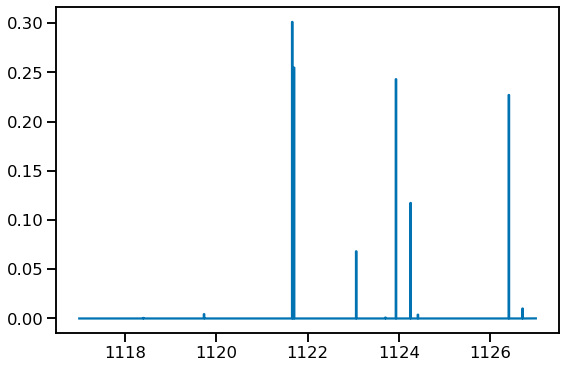

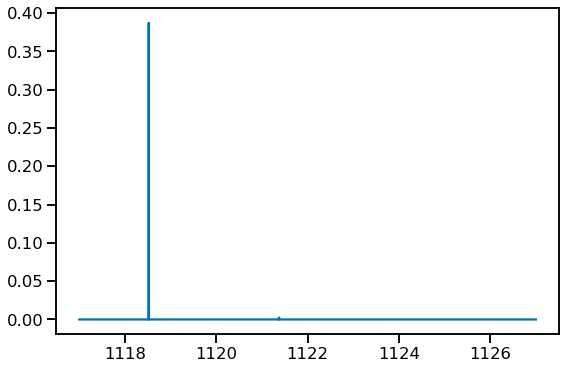

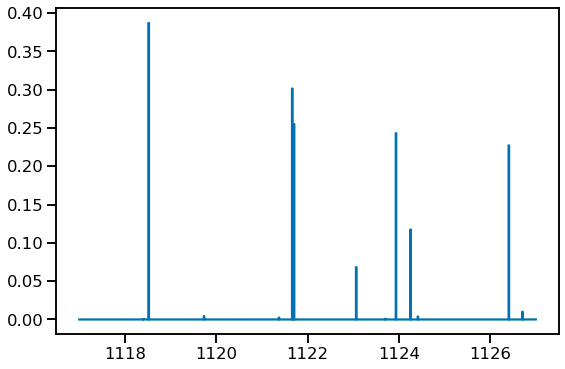

In [8]:
f_arr_A, z_prob_A = efold_search(events[0], f_min=1117., f_max=1127., f_steps=1000, time_intervals = burst2_gti, nbin = 32, pi_min = 35, pi_max = 260)
f_arr_B, z_prob_B = efold_search(events[1], f_min=1117., f_max=1127., f_steps=1000, time_intervals = burst2_gti, nbin = 32, pi_min = 35, pi_max = 260)
    
plt.figure(figsize= (9,6))
plt.step(f_arr_A, z_prob_A, where='mid')
print(np.max(z_prob_A))
print(f_arr_A[np.argmax(z_prob_A)])

plt.figure(figsize= (9,6))
plt.step(f_arr_B, z_prob_B, where='mid')
print(np.max(z_prob_B))
print(f_arr_B[np.argmax(z_prob_B)])

total_prob = z_prob_A + z_prob_B - (z_prob_A * z_prob_B)
plt.figure(figsize= (9,6))
plt.step(f_arr_A, total_prob, where='mid')
print(np.max(total_prob))
print(f_arr_A[np.argmax(total_prob)])    

## Persistent Cospectra

In [32]:
gti_lens = np.array([(g[1]-g[0]) for g in sting_gti.cross_two_gtis(events[0].gti, persistent_gti)])
len_mask = gti_lens > 500.
split_time = minimize_remainder(gti_lens[len_mask], 500,1500)
print(split_time)
ms_bin = 0.0001
f_res = 0.05

# print(events[0].split_by_time(bintime=split_time))
curves_A = [x.to_lc(dt = ms_bin, pi_low=PI_min, pi_high=PI_max, centroid = centroid_A, radius = extraction_radius) for x in events[0].split_by_time(bintime=split_time, gti=persistent_gti)]
curves_B = [x.to_lc(dt = ms_bin, pi_low=PI_min, pi_high=PI_max, centroid = centroid_B, radius = extraction_radius) for x in events[1].split_by_time(bintime=split_time, gti=persistent_gti)]


530.3030303030303


In [33]:
plt.ioff()

cross_spectra = []
for i in tqdm(range(len(curves_A))):
    cross = crossspec.Crossspectrum(curves_A[i], curves_B[i], norm='leahy')
    cross_spectra.append(cross)
    cross_log = cross.rebin_log(f=f_res)
    temp_err = cross.df*np.power(1.+f_res, range(len(cross_log.freq)))/2
#     cross_lin = cross.rebin(df=1)
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
#     res_mask = cross_log.freq > cross.df/f_re
    ax1.errorbar(cross_log.freq, cross_log.power.real, xerr=temp_err, yerr=cross_log.power_err, fmt='none', lw=0.2)
#     ax1.errorbar(cross.freq, cross.power.real*cross.freq, xerr=cross.df/2, yerr=cross.power_err*cross.freq, fmt='')
#     ax1.set_xlim(1./split_time,1./(2.*ms_bin))
#     ax1.axvline(1122, ls='--', color='red')
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Leahy power')
    ax1.set_ylim(1e-6,100.)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax2.errorbar(curve_10s.time, curve_10s.countrate, xerr=curve_10s.dt/2, yerr=curve_10s.countrate_err, fmt='none')
    ax2.axvspan(np.min(curves_A[i].time),np.max(curves_A[i].time), facecolor='red', alpha = 0.2)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel(r'$\mathrm{Count\ rate\ (s^{-1})}$')
    plt.tight_layout()
    plt.savefig(plot_dir + 'persistent_cross_spectrum_log_' + str(int(split_time)) + 's_segment' + str(i) + '.pdf')  
    plt.close()
    cross_file = open(timing_dir + 'analysis_products/' + 'persistent_cross_spectrum_' + str(int(split_time)) + 's_segment' + str(i) + '.txt', 'wb')
    pickle.dump(cross, cross_file)
    cross_file.close()
    

  0%|          | 0/53 [00:00<?, ?it/s]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
  2%|▏         | 1/53 [00:40<35:21, 40.79s/it]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
  4%|▍         | 2/53 [01:20<34:25, 40.50s/it]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
  6%|▌         | 3/53 [02:02<34:03, 40.87s/it]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning

In [ ]:
# cross_spectra = []
# for i in tqdm(range(len(curves_A))):
#     cross_file = open(timing_dir + 'analysis_products/' + 'persistent_cross_spectrum_' + str(int(split_time)) + 's_segment' + str(i) + '.txt', 'wb')
#     cross = pickle.load(cross_file)
#     cross_file.close()
#     cross_spectra.append(cross)


In [8]:
plt.ion()

averaged_cross = cross_spectra[0]

averaged_cross.m = len(cross_spectra)

for i in range(len(cross_spectra))[1:]:
    averaged_cross.power += cross_spectra[i].power
    averaged_cross.unnorm_power += cross_spectra[i].unnorm_power
    averaged_cross.power_err += np.square(cross_spectra[i].power_err)
    averaged_cross.nphots1 += cross_spectra[i].nphots1
    averaged_cross.nphots2 += cross_spectra[i].nphots2
    
averaged_cross.power = averaged_cross.power/averaged_cross.m
averaged_cross.unnorm_power = averaged_cross.unnorm_power/averaged_cross.m
averaged_cross.power_err = np.sqrt(averaged_cross.power_err)/averaged_cross.m
averaged_cross.nphots1 = averaged_cross.nphots1/averaged_cross.m
averaged_cross.nphots2 = averaged_cross.nphots2/averaged_cross.m
    
f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.2)
plt.xscale('log')
# plt.xlim((1./split_time) - (averaged_cross.df/2.),1./(2.*ms_bin))
# plt.xlim((1./split_time) - (averaged_cross.df),10.)
plt.ylim((1e-4,2.))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'persistent_averaged_cross_spectrum_' + str(int(split_time)) + 's.pdf')
plt.close()

f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real*averaged_cross_log.freq, xerr=temp_err, yerr=averaged_cross_log.power_err*averaged_cross_log.freq, fmt='none', lw=0.5)
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.2)
plt.xscale('log')
# plt.xlim((1./split_time) - (averaged_cross.df/2.),1./(2.*ms_bin))
plt.xlim((1./split_time) - (averaged_cross.df),0.5)
plt.ylim((1e-3,1.0))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'persistent_averaged_cross_spectrum_' + str(int(split_time)) + 's_lowf.pdf')
plt.close()

f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.2)
plt.xscale('log')
# plt.xlim((1./split_time) - (averaged_cross.df/2.),1./(2.*ms_bin))
plt.xlim((0.3, 2500.))
plt.ylim((1e-4,2.))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'persistent_averaged_cross_spectrum_' + str(int(split_time)) + 's_highf.pdf')
plt.close()

/Users/sean/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


## Burst Cospectra

In [9]:
gti_lens = np.array([(g[1]-g[0]) for g in sting_gti.cross_two_gtis(events[0].gti, burst_gti)])
split_time = minimize_remainder(gti_lens, 10.,1000.)
print(split_time)
ms_bin = 0.0001
f_res = 0.05

# print(events[0].split_by_time(bintime=split_time))
curves_A = [x.to_lc(dt = ms_bin, pi_low=PI_min, pi_high=PI_max, centroid = centroid_A, radius = extraction_radius) for x in events[0].split_by_time(bintime=split_time, gti=burst_gti)]
curves_B = [x.to_lc(dt = ms_bin, pi_low=PI_min, pi_high=PI_max, centroid = centroid_B, radius = extraction_radius) for x in events[1].split_by_time(bintime=split_time, gti=burst_gti)]

print(curves_A[0].time)


10.0
[3.19824471e+08 3.19824471e+08 3.19824471e+08 ... 3.19824481e+08
 3.19824481e+08 3.19824481e+08]


In [10]:
plt.ioff()

cross_spectra = []
for i in tqdm(range(len(curves_A))):
    cross = crossspec.Crossspectrum(curves_A[i], curves_B[i], norm='leahy')
    cross_spectra.append(cross)
    cross_log = cross.rebin_log(f=f_res)
    temp_err = cross.df*np.power(1.+f_res, range(len(cross_log.freq)))/2
#     cross_lin = cross.rebin(df=1)
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
#     res_mask = cross_log.freq > cross.df/f_re
    ax1.errorbar(cross_log.freq, cross_log.power.real, xerr=temp_err, yerr=cross_log.power_err, fmt='none', lw=0.2)
#     ax1.errorbar(cross.freq, cross.power.real*cross.freq, xerr=cross.df/2, yerr=cross.power_err*cross.freq, fmt='')
#     ax1.set_xlim(1./split_time,1./(2.*ms_bin))
#     ax1.axvline(1122, ls='--', color='red')
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Leahy power')
    ax1.set_ylim(1e-6,1000.)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax2.errorbar(curve_total.time, curve_total.countrate, xerr=curve_total.dt/2, yerr=curve_total.countrate_err, fmt='none')
    ax2.axvspan(np.min(curves_A[i].time),np.max(curves_A[i].time), facecolor='red', alpha = 0.2)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel(r'$\mathrm{Count\ rate\ (s^{-1})}$')
    plt.tight_layout()
    plt.savefig(plot_dir + 'burst_cross_spectrum_log_' + str(int(split_time)) + 's_segment' + str(i) + '.pdf')  
    plt.close()

    cross_file = open(timing_dir + 'analysis_products/burst_cross_spectrum_' + str(int(split_time)) + 's_segment' + str(i) + '.txt', 'wb')
    pickle.dump(cross, cross_file)
    cross_file.close()
    

  0%|          | 0/7 [00:00<?, ?it/s]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
 14%|█▍        | 1/7 [00:14<01:27, 14.53s/it]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
 29%|██▊       | 2/7 [00:30<01:14, 14.91s/it]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
 43%|████▎     | 3/7 [00:47<01:02, 15.51s/it]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SI

In [12]:
## plt.ion()

averaged_cross = cross_spectra[0]

averaged_cross.m = len(cross_spectra)

for i in range(len(cross_spectra))[1:]:
    averaged_cross.power += cross_spectra[i].power
    averaged_cross.unnorm_power += cross_spectra[i].unnorm_power
    averaged_cross.power_err += np.square(cross_spectra[i].power_err)
    averaged_cross.nphots1 += cross_spectra[i].nphots1
    averaged_cross.nphots2 += cross_spectra[i].nphots2
    
averaged_cross.power = averaged_cross.power/averaged_cross.m
averaged_cross.unnorm_power = averaged_cross.unnorm_power/averaged_cross.m
averaged_cross.power_err = np.sqrt(averaged_cross.power_err)/averaged_cross.m
averaged_cross.nphots1 = averaged_cross.nphots1/averaged_cross.m
averaged_cross.nphots2 = averaged_cross.nphots2/averaged_cross.m
    
f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.2)
plt.xscale('log')
# plt.xlim((1./split_time) - (averaged_cross.df/2.),1./(2.*ms_bin))
# plt.xlim((1./split_time) - (averaged_cross.df),10.)
plt.ylim((1e-2,100.))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'burst_averaged_cross_spectrum_' + str(int(split_time)) + 's.pdf')
plt.close()

f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.2)
plt.xscale('log')
# plt.xlim((1./split_time) - (averaged_cross.df/2.),1./(2.*ms_bin))
plt.xlim((1./split_time) - (averaged_cross.df),10.)
plt.ylim((1e-2,100.0))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'burst_averaged_cross_spectrum_' + str(int(split_time)) + 's_lowf.pdf')
plt.close()

f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.2)
plt.xscale('log')
# plt.xlim((1./split_time) - (averaged_cross.df/2.),1./(2.*ms_bin))
plt.xlim((10.0, 3000.))
plt.ylim((1e-2,100.))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'burst_averaged_cross_spectrum_' + str(int(split_time)) + 's_highf.pdf')
plt.close()

/Users/sean/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


## Pre-Burst Cospectra

In [6]:
gti_lens = np.array([(g[1]-g[0]) for g in sting_gti.cross_two_gtis(events[0].gti, pre_burst1_gti)])
split_time = minimize_remainder(gti_lens, 500.,2000.)
print(split_time)
ms_bin = 0.0001
f_res = 0.05

PI_min = 35     # 3.0 keV
PI_min = 260     # 12.0 keV

# print(events[0].split_by_time(bintime=split_time))
curves_A = [x.to_lc(dt = ms_bin, pi_low=PI_min, pi_high=PI_max, centroid = centroid_A, radius = extraction_radius) for x in events[0].split_by_time(bintime=split_time, gti=pre_burst1_gti)]
curves_B = [x.to_lc(dt = ms_bin, pi_low=PI_min, pi_high=PI_max, centroid = centroid_B, radius = extraction_radius) for x in events[1].split_by_time(bintime=split_time, gti=pre_burst1_gti)]

print(curves_A[0].time)


530.3030303030303
[3.19814714e+08 3.19814714e+08 3.19814714e+08 ... 3.19815245e+08
 3.19815245e+08 3.19815245e+08]


In [7]:
plt.ioff()

cross_spectra = []
for i in tqdm(range(len(curves_A))):
    cross = crossspec.Crossspectrum(curves_A[i], curves_B[i], norm='leahy')
    cross_spectra.append(cross)
    cross_log = cross.rebin_log(f=f_res)
    temp_err = cross.df*np.power(1.+f_res, range(len(cross_log.freq)))/2
#     cross_lin = cross.rebin(df=1)
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
#     res_mask = cross_log.freq > cross.df/f_re
    ax1.errorbar(cross_log.freq, cross_log.power.real, xerr=temp_err, yerr=cross_log.power_err, fmt='none', lw=0.2)
#     ax1.errorbar(cross.freq, cross.power.real*cross.freq, xerr=cross.df/2, yerr=cross.power_err*cross.freq, fmt='')
#     ax1.set_xlim(1./split_time,1./(2.*ms_bin))
#     ax1.axvline(1122, ls='--', color='red')
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Leahy power')
    ax1.set_ylim(1e-6,1000.)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax2.errorbar(curve_total.time, curve_total.countrate, xerr=curve_total.dt/2, yerr=curve_total.countrate_err, fmt='none')
    ax2.axvspan(np.min(curves_A[i].time),np.max(curves_A[i].time), facecolor='red', alpha = 0.2)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel(r'$\mathrm{Count\ rate\ (s^{-1})}$')
    plt.tight_layout()
    plt.savefig(plot_dir + 'pre_burst1_cross_spectrum_log_' + str(int(split_time)) + 's_segment' + str(i) + '.pdf')  
    plt.close()

    cross_file = open(timing_dir + 'analysis_products/preburst1_cross_spectrum_' + str(int(split_time)) + 's_segment' + str(i) + '.txt', 'wb')
    pickle.dump(cross, cross_file)
    cross_file.close()
    

  0%|          | 0/6 [00:00<?, ?it/s]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
 17%|█▋        | 1/6 [00:56<04:43, 56.66s/it]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
 33%|███▎      | 2/6 [01:54<03:48, 57.13s/it]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
 50%|█████     | 3/6 [02:54<02:53, 57.75s/it]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SI

In [8]:
## plt.ion()

averaged_cross = cross_spectra[0]

averaged_cross.m = len(cross_spectra)

for i in range(len(cross_spectra))[1:]:
    averaged_cross.power += cross_spectra[i].power
    averaged_cross.unnorm_power += cross_spectra[i].unnorm_power
    averaged_cross.power_err += np.square(cross_spectra[i].power_err)
    averaged_cross.nphots1 += cross_spectra[i].nphots1
    averaged_cross.nphots2 += cross_spectra[i].nphots2
    
averaged_cross.power = averaged_cross.power/averaged_cross.m
averaged_cross.unnorm_power = averaged_cross.unnorm_power/averaged_cross.m
averaged_cross.power_err = np.sqrt(averaged_cross.power_err)/averaged_cross.m
averaged_cross.nphots1 = averaged_cross.nphots1/averaged_cross.m
averaged_cross.nphots2 = averaged_cross.nphots2/averaged_cross.m
    
f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.2)
plt.xscale('log')
# plt.xlim((1./split_time) - (averaged_cross.df/2.),1./(2.*ms_bin))
# plt.xlim((1./split_time) - (averaged_cross.df),10.)
plt.ylim((1e-4,3.))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'preburst1_averaged_cross_spectrum_' + str(int(split_time)) + 's.pdf')
plt.close()

f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.2)
plt.xscale('log')
# plt.xlim((1./split_time) - (averaged_cross.df/2.),1./(2.*ms_bin))
plt.xlim((1./split_time) - (averaged_cross.df),10.)
plt.ylim((1e-3,3.0))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'preburst1_averaged_cross_spectrum_' + str(int(split_time)) + 's_lowf.pdf')
plt.close()

f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.2)
plt.xscale('log')
# plt.xlim((1./split_time) - (averaged_cross.df/2.),1./(2.*ms_bin))
plt.xlim((10.0, 3000.))
plt.ylim((1e-4,3.))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'preburst1_averaged_cross_spectrum_' + str(int(split_time)) + 's_highf.pdf')
plt.close()

/Users/sean/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


In [10]:
gti_lens = np.array([(g[1]-g[0]) for g in sting_gti.cross_two_gtis(events[0].gti, pre_burst2_gti)])
split_time = minimize_remainder(gti_lens, 500.,1000.)
print(split_time)
ms_bin = 0.0001
f_res = 0.05

# print(events[0].split_by_time(bintime=split_time))
curves_A = [x.to_lc(dt = ms_bin, pi_low=PI_min, pi_high=PI_max, centroid = centroid_A, radius = extraction_radius) for x in events[0].split_by_time(bintime=split_time, gti=pre_burst2_gti)]
curves_B = [x.to_lc(dt = ms_bin, pi_low=PI_min, pi_high=PI_max, centroid = centroid_B, radius = extraction_radius) for x in events[1].split_by_time(bintime=split_time, gti=pre_burst2_gti)]

print(curves_A[0].time)


590.9090909090909
[3.19829428e+08 3.19829428e+08 3.19829428e+08 ... 3.19830018e+08
 3.19830018e+08 3.19830018e+08]


In [11]:
plt.ioff()

cross_spectra = []
for i in tqdm(range(len(curves_A))):
    cross = crossspec.Crossspectrum(curves_A[i], curves_B[i], norm='leahy')
    cross_spectra.append(cross)
    cross_log = cross.rebin_log(f=f_res)
    temp_err = cross.df*np.power(1.+f_res, range(len(cross_log.freq)))/2
#     cross_lin = cross.rebin(df=1)
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
#     res_mask = cross_log.freq > cross.df/f_re
    ax1.errorbar(cross_log.freq, cross_log.power.real, xerr=temp_err, yerr=cross_log.power_err, fmt='none', lw=0.2)
#     ax1.errorbar(cross.freq, cross.power.real*cross.freq, xerr=cross.df/2, yerr=cross.power_err*cross.freq, fmt='')
#     ax1.set_xlim(1./split_time,1./(2.*ms_bin))
#     ax1.axvline(1122, ls='--', color='red')
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Leahy power')
    ax1.set_ylim(1e-6,1000.)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax2.errorbar(curve_total.time, curve_total.countrate, xerr=curve_total.dt/2, yerr=curve_total.countrate_err, fmt='none')
    ax2.axvspan(np.min(curves_A[i].time),np.max(curves_A[i].time), facecolor='red', alpha = 0.2)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel(r'$\mathrm{Count\ rate\ (s^{-1})}$')
    plt.tight_layout()
    plt.savefig(plot_dir + 'preburst2_cross_spectrum_log_' + str(int(split_time)) + 's_segment' + str(i) + '.pdf')  
    plt.close()

    cross_file = open(timing_dir + 'analysis_products/preburst2_cross_spectrum_' + str(int(split_time)) + 's_segment' + str(i) + '.txt', 'wb')
    pickle.dump(cross, cross_file)
    cross_file.close()
    

  0%|          | 0/10 [00:00<?, ?it/s]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
 10%|█         | 1/10 [01:06<10:00, 66.74s/it]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
 20%|██        | 2/10 [02:08<08:41, 65.15s/it]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
 30%|███       | 3/10 [03:09<07:27, 63.94s/it]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning

In [13]:
## plt.ion()

averaged_cross = cross_spectra[0]

averaged_cross.m = len(cross_spectra)

for i in range(len(cross_spectra))[1:]:
    averaged_cross.power += cross_spectra[i].power
    averaged_cross.unnorm_power += cross_spectra[i].unnorm_power
    averaged_cross.power_err += np.square(cross_spectra[i].power_err)
    averaged_cross.nphots1 += cross_spectra[i].nphots1
    averaged_cross.nphots2 += cross_spectra[i].nphots2
    
averaged_cross.power = averaged_cross.power/averaged_cross.m
averaged_cross.unnorm_power = averaged_cross.unnorm_power/averaged_cross.m
averaged_cross.power_err = np.sqrt(averaged_cross.power_err)/averaged_cross.m
averaged_cross.nphots1 = averaged_cross.nphots1/averaged_cross.m
averaged_cross.nphots2 = averaged_cross.nphots2/averaged_cross.m
    
f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.2)
plt.xscale('log')
# plt.xlim((1./split_time) - (averaged_cross.df/2.),1./(2.*ms_bin))
# plt.xlim((1./split_time) - (averaged_cross.df),10.)
plt.ylim((1e-4,10.))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'preburst2_averaged_cross_spectrum_' + str(int(split_time)) + 's.pdf')
plt.close()

f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.2)
plt.xscale('log')
# plt.xlim((1./split_time) - (averaged_cross.df/2.),1./(2.*ms_bin))
plt.xlim((1./split_time) - (averaged_cross.df),10.)
plt.ylim((1e-3,10.0))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'preburst2_averaged_cross_spectrum_' + str(int(split_time)) + 's_lowf.pdf')
plt.close()

f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.2)
plt.xscale('log')
# plt.xlim((1./split_time) - (averaged_cross.df/2.),1./(2.*ms_bin))
plt.xlim((10.0, 3000.))
plt.ylim((1e-4,3.))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'preburst2_averaged_cross_spectrum_' + str(int(split_time)) + 's_highf.pdf')
plt.close()

/Users/sean/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


# 2019

In [22]:
if platform=='linux' or platform=='linux2':
    print('Working on SRL server')
    root_dir = '/disk/lif2/spike/J1739m285/nustar/2019/'
elif platform=='darwin':
    print('Working on Macbook')
    root_dir='/Volumes/Samsung_1TB/AstroData/J1739m285/nustar/2019/'

timing_dir = root_dir + 'timing_products/'
products_dir = root_dir + 'products_3to78keV/'
plot_dir = root_dir + 'figures/'

OBSID = '90501343002'
    

Working on Macbook


/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:375: RuntimeWarning: underflow encountered in exp
  (c * ydiff ** 2)))
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:399: RuntimeWarning: underflow encountered in exp
  (c * ydiff2)))
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:409: RuntimeWarning: underflow encountered in true_divide
  dg_dA = g / amplitude
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:410: RuntimeWarning: underflow encountered in multiply
  dg_dx_mean = g * ((2. * a * xdiff) + (b * ydiff))
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:411: RuntimeWarning: underflow encountered in multiply
  dg_dy_mean = g * ((b * xdiff) + (2. * c * ydiff))
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:414: RuntimeWarning: underflow encountered i

Text(0, 0.5, 'NuSTAR count rate')

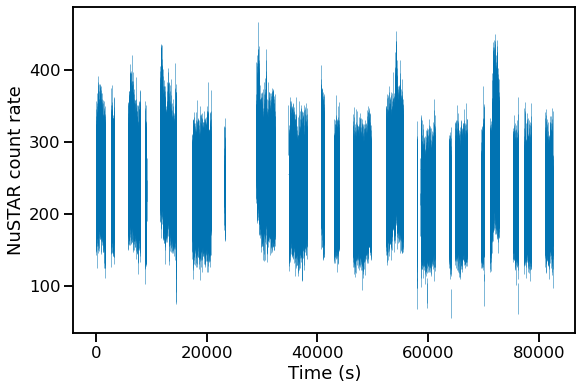

In [23]:
PI_min = 35     # 3.0 keV
# PI_min = 260     # 12.0 keV
PI_max = 960   # 40.0 keV
# PI_max = 1909   # 78.0 keV
events = extract_events(timing_dir + 'nu' + OBSID + 'A01_cl_barycorr.evt', \
            timing_dir + 'nu' + OBSID + 'B01_cl_barycorr.evt')

centroid_A = [455.58026,549.43098]
centroid_B = [460.58411,550.4489]
extraction_radius = 46.783962

events[0].set_xy_weights(centroid=centroid_A)
events[1].set_xy_weights(centroid=centroid_B)
# joined_events = events[0].join(events[1])
# print(events[0].time)

hk_files = [fits.open(timing_dir + 'nu'+ OBSID +'A_fpm_bc.hk'), fits.open(timing_dir + 'nu'+ OBSID +'B_fpm_bc.hk')]
hk_data_A = hk_files[0][1].data

plt.ion()

curveA = bkg_subtract(nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'A01_sr.lc'), nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'A01_bk.lc'))
curveB = bkg_subtract(nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'B01_sr.lc'), nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'B01_bk.lc'))
curve_total = sum_lc(curveA, curveB)
curve_10s = curve_total.rebin(dt_new=10)

t_start = np.min(curve_total.time)

plt.figure(figsize = (9,6))
plt.errorbar(curve_total.time-t_start, curve_total.countrate, xerr=curve_total.dt/2., yerr=curve_total.countrate_err, fmt='none', lw = 0.5)
plt.xlabel('Time (s)')
plt.ylabel('NuSTAR count rate')
# plt.close()





307665813.59591
307665812.59554315
-1.0003668665885925


<IPython.core.display.Javascript object>


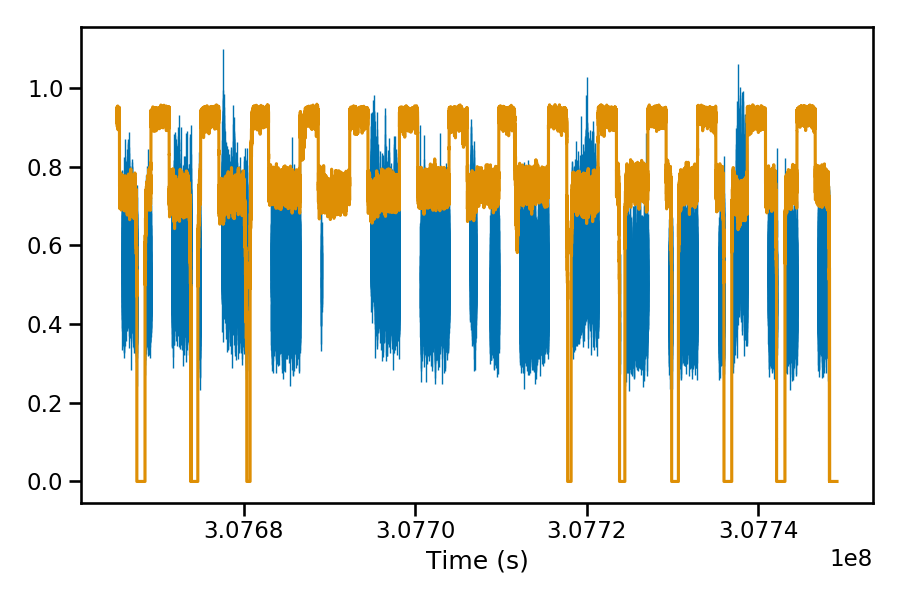

6088


<IPython.core.display.Javascript object>


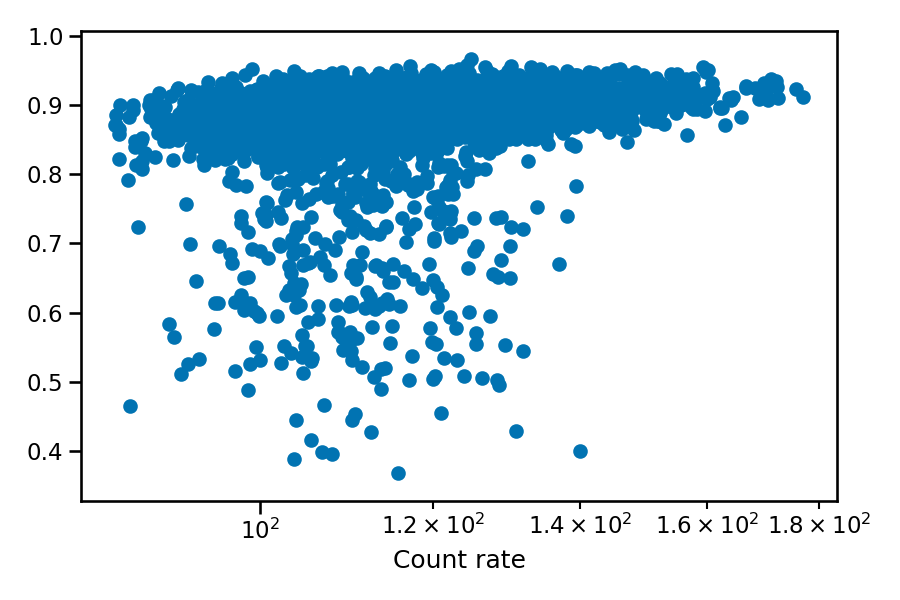

<IPython.core.display.Javascript object>


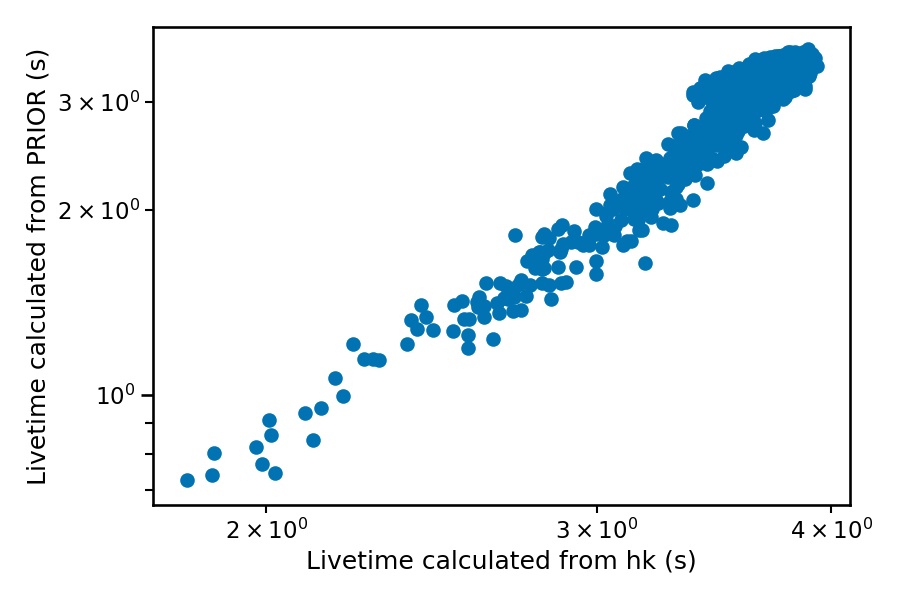

In [4]:
plt.figure(figsize=(9,6))
plt.errorbar(curve.time, curve.countrate/np.max(curve.countrate), xerr = curve.dt/2, yerr=curve.countrate_err/np.max(curve.countrate), fmt='none', lw=1.0)
plt.step(hk_data_A['TIME'], hk_data_A['LIVETIME'], where='mid')
plt.xlabel('Time (s)')
# plt.ylabel('Count rate')
plt.tight_layout()

livetime_prior = []
livetime_hk = []
livetime_rate = []
livetime_time = []

for i in range(len(curve.time)-5):
    if (curve.time[i+4] - curve.time[i] < 4.1) and (not i%5):
        hk_mask = (hk_data_A['TIME'] > curve.time[i]-0.1) * (hk_data_A['TIME'] < curve.time[i+5] + 0.1)
        if np.sum(hk_mask) == 5:
#             print('hk mask length: ' + str(np.sum(hk_mask)))
            ev_mask = (events[0].time > hk_data_A['TIME'][hk_mask][0]) * (events[0].time < (hk_data_A['TIME'][hk_mask][-1] + 1.0))

            livetime_time.append(np.mean(hk_data_A['TIME'][hk_mask] + 0.5))
            livetime_rate.append(np.mean(curve.countrate[i:i+5]))
            livetime_hk.append(np.sum(hk_data_A['LIVETIME'][hk_mask]))
            prior_temp = 0.0

            if np.sum(ev_mask) > 0:
                prior_temp += np.min([events[0].prior[ev_mask][0], events[0].time[ev_mask][0] -  hk_data_A['TIME'][hk_mask][0]])
                if np.sum(ev_mask) > 1:
                    prior_temp += np.sum(events[0].prior[ev_mask][1:])

                if events[0].time[ev_mask][0] - events[0].prior[ev_mask][0] < hk_data_A['TIME'][hk_mask][0]:
                    if len(livetime_time) > 1:
                        if livetime_time[-1] - livetime_time[-2] < 6.0:
                            livetime_prior[-1] += events[0].prior[ev_mask][0] - (events[0].time[ev_mask][0] - hk_data_A['TIME'][hk_mask][0])
            livetime_prior.append(prior_temp)
        
print(len(livetime_prior))
livetime_time = np.array(livetime_time)
livetime_rate = np.array(livetime_rate)
livetime_hk = np.array(livetime_hk)
livetime_prior = np.array(livetime_prior)

plt.figure(figsize=(9,6))
plt.scatter(livetime_rate, livetime_prior/livetime_hk)
plt.xlabel('Count rate')
plt.xscale('log')
# plt.ylabel('Count rate')
plt.tight_layout()

plt.figure(figsize=(9,6))
plt.scatter(livetime_hk, livetime_prior)
plt.xlabel('Livetime calculated from hk (s)')
plt.ylabel('Livetime calculated from PRIOR (s)')
plt.loglog()
# plt.ylabel('Count rate')
plt.tight_layout()



/Users/sean/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:175: RuntimeWarning: underflow encountered in true_divide


<IPython.core.display.Javascript object>


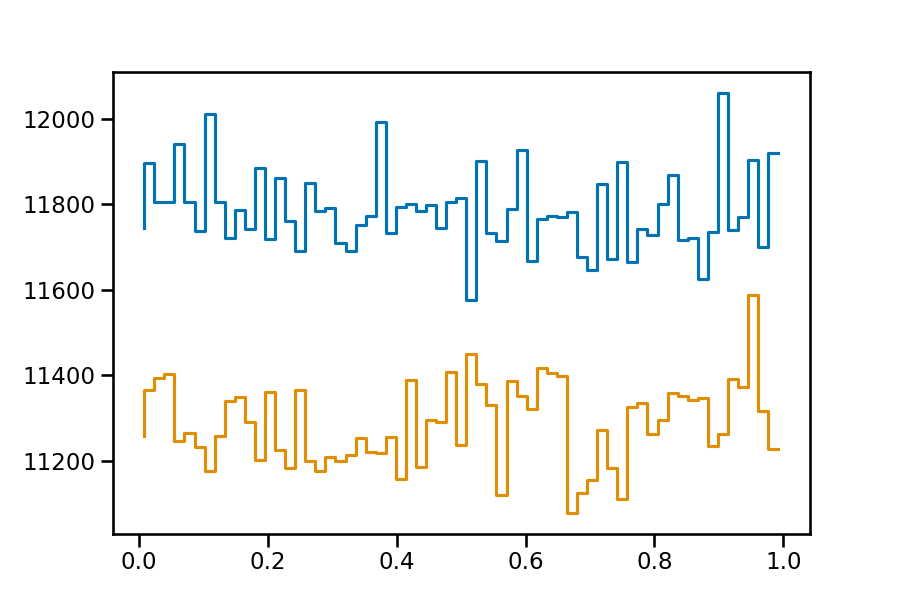

<IPython.core.display.Javascript object>


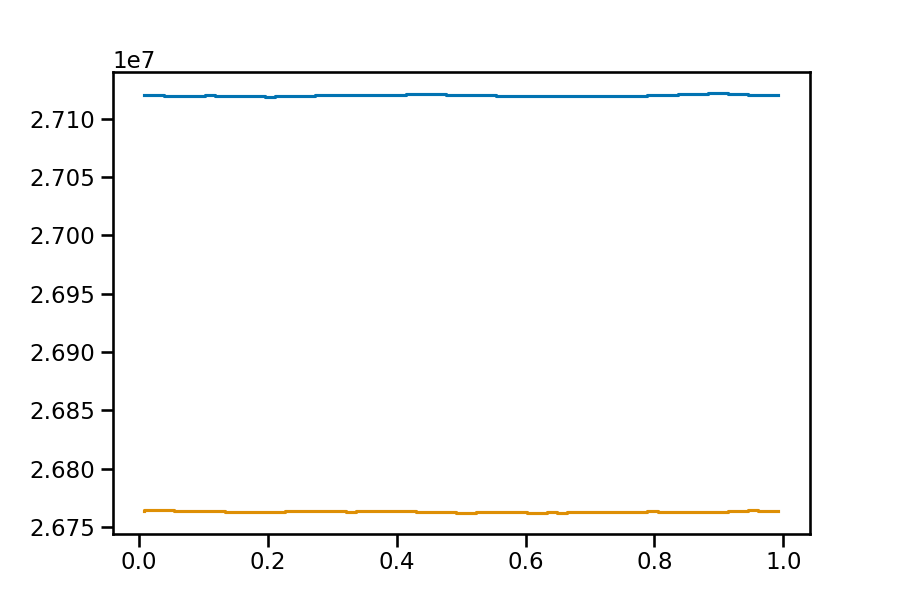

<IPython.core.display.Javascript object>


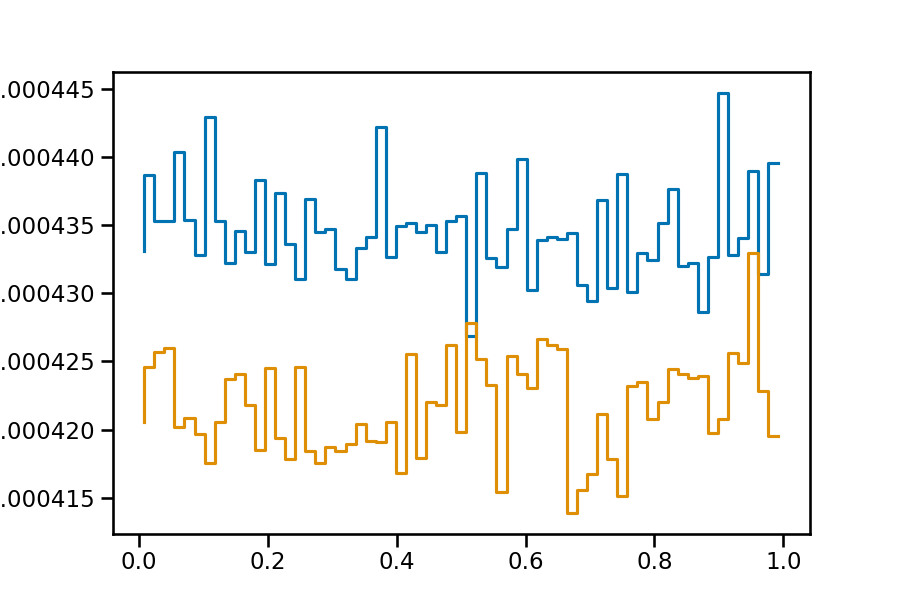

<IPython.core.display.Javascript object>


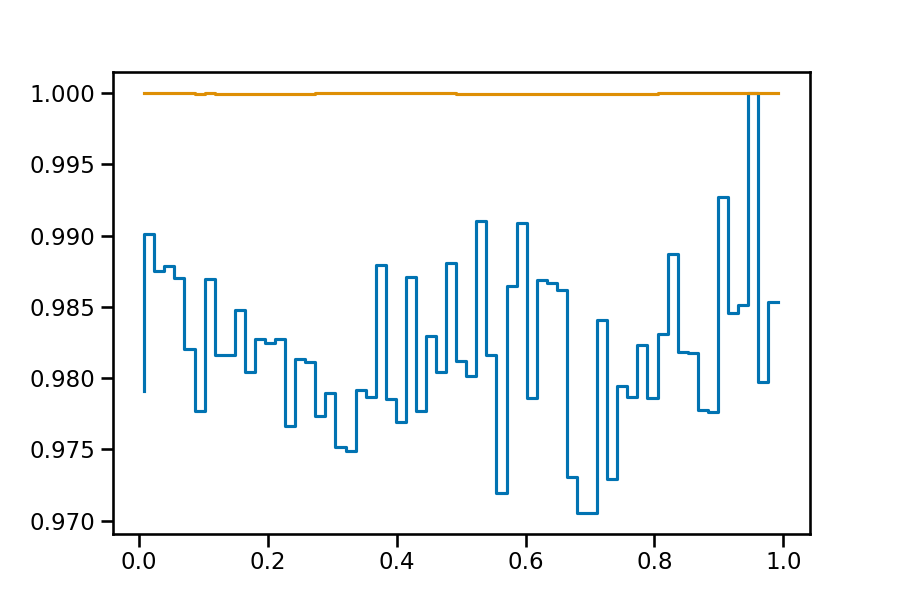

In [7]:
phase_bins_A, profile_A, profile_err_A, livetime_profile_A, z_stat_A = \
        events[0].fold_events_ltcorr(1122., nbin = 64, ref_time = events[0].time[0], region_filter=False, \
                                     pi_min = 35, pi_max = 260, weight_pos=True)
phase_bins_B, profile_B, profile_err_B, livetime_profile_B, z_stat_B = \
        events[1].fold_events_ltcorr(1122., nbin = 64, ref_time = events[0].time[0], region_filter=False, \
                                    pi_min = 35, pi_max = 260, weight_pos=True)


plt.figure(figsize=(9,6))
plt.step(phase_bins_A, profile_A)
plt.step(phase_bins_B, profile_B)

plt.figure(figsize=(9,6))
plt.step(phase_bins_A, livetime_profile_A)
plt.step(phase_bins_B, livetime_profile_B)

plt.figure(figsize=(9,6))
plt.step(phase_bins_A, profile_A/livetime_profile_A)
plt.step(phase_bins_B, profile_B/livetime_profile_B)

plt.figure(figsize=(9,6))
plt.step(phase_bins_A, (profile_A + profile_B)/(livetime_profile_A + livetime_profile_B)/np.max((profile_A + profile_B)/(livetime_profile_A + livetime_profile_B)))
plt.step(phase_bins_A, (livetime_profile_A + livetime_profile_B)/np.max(livetime_profile_A + livetime_profile_B))

# plt.figure(figsize=(9,6))
# plt.step(phase_bins_A, (profile_A/livetime_profile_A) + (profile_B/livetime_profile_B))



In [24]:
f_min = 1175.
f_max = 1225.
f_steps = 50
f_arr = np.linspace(f_min, f_max, num = f_steps)
nbin = 32
z_stats = []
for f in tqdm(f_arr):
    phase_bins_A, profile_A, profile_err_A, livetime_profile_A, z_stat_A = \
        events[0].fold_events_ltcorr(f, nbin = nbin, ref_time = events[0].time[0], region_filter=False, \
                                     pi_min=35, pi_max=960, weight_pos=True)
    phase_bins_B, profile_B, profile_err_B, livetime_profile_B, z_stat_B = \
        events[1].fold_events_ltcorr(f, nbin = nbin, ref_time = events[0].time[0], region_filter=False, \
                                     pi_min=35, pi_max=960, weight_pos=True)
    
#     summed_profile = np.mean(livetime_profile_A + livetime_profile_B) * (profile_A + profile_B)/(livetime_profile_A + livetime_profile_B)
#     summed_err = np.mean(livetime_profile_A + livetime_profile_B) * np.sqrt(np.square(profile_err_A) + np.square(profile_err_B))/(livetime_profile_A + livetime_profile_B)
#     summed_stat = plsr.stat(summed_profile, err=summed_err)
#     summed_real = 1.0 - plsr.fold_profile_probability(summed_stat, nbin)
    z_stats.append(z_stat_A)

z_stats = np.array(z_stats)

plt.figure(figsize= (9,6))
plt.step(f_arr, z_stats, where='mid')
    

  0%|          | 0/50 [00:36<?, ?it/s]


KeyboardInterrupt: 

In [25]:
gti_lens = np.array([(g[1]-g[0]) for g in events[0].gti])
len_mask = gti_lens > 500.
split_time = minimize_remainder(gti_lens[len_mask], 500,1500)
print(split_time)
ms_bin = 0.0002
f_res = 0.05

# print(events[0].split_by_time(bintime=split_time))
curves_A = [x.to_lc(dt = ms_bin, centroid = centroid_A, radius=extraction_radius) for x in events[0].split_by_time(bintime=split_time)]
curves_B = [x.to_lc(dt = ms_bin, centroid = centroid_B, radius=extraction_radius) for x in events[1].split_by_time(bintime=split_time)]


540.4040404040404


In [26]:
plt.ioff()

cross_spectra = []

for i in tqdm(range(len(curves_A))):
    cross = crossspec.Crossspectrum(curves_A[i], curves_B[i], norm='leahy')
    cross_spectra.append(cross)
    cross_log = cross.rebin_log(f=f_res)
    temp_err = cross.df*np.power(1.+f_res, range(len(cross_log.freq)))/2
#     cross_lin = cross.rebin(df=1)
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
#     res_mask = cross_log.freq > cross.df/f_re
    ax1.errorbar(cross_log.freq, cross_log.power.real, xerr=temp_err, yerr=cross_log.power_err, fmt='none', lw=0.2)
#     ax1.errorbar(cross.freq, cross.power.real*cross.freq, xerr=cross.df/2, yerr=cross.power_err*cross.freq, fmt='')
#     ax1.set_xlim(1./split_time,1./(2.*ms_bin))
#     ax1.axvline(1122, ls='--', color='red')
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Leahy power')
    ax1.set_ylim(1e-6, 100.)
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax2.errorbar(curve_10s.time, curve_10s.countrate, xerr=curve_10s.dt/2, yerr=curve_10s.countrate_err, fmt='none')
    ax2.axvspan(np.min(curves_A[i].time),np.max(curves_A[i].time), facecolor='red', alpha = 0.2)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel(r'$\mathrm{Count\ rate\ (s^{-1})}$')
    plt.tight_layout()
    plt.savefig(plot_dir + 'cross_spectrum_log_' + str(int(split_time)) + 's_segment' + str(i) + '.pdf')
    plt.close()
    
    cross_file = open(timing_dir + 'analysis_products/cross_spectrum_' + str(int(split_time)) + 's_segment' + str(i) + '.txt', 'wb')
    pickle.dump(cross, cross_file)
    cross_file.close()
    

  0%|          | 0/59 [00:00<?, ?it/s]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
  2%|▏         | 1/59 [00:19<19:16, 19.94s/it]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
  3%|▎         | 2/59 [00:41<19:28, 20.50s/it]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
  5%|▌         | 3/59 [01:02<19:13, 20.60s/it]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning

In [28]:
plt.ion()

averaged_cross = cross_spectra[0]

averaged_cross.m = len(cross_spectra)

for i in range(len(cross_spectra))[1:]:
    averaged_cross.power += cross_spectra[i].power
    averaged_cross.unnorm_power += cross_spectra[i].unnorm_power
    averaged_cross.power_err += np.square(cross_spectra[i].power_err)
    averaged_cross.nphots1 += cross_spectra[i].nphots1
    averaged_cross.nphots2 += cross_spectra[i].nphots2
    
averaged_cross.power = averaged_cross.power/averaged_cross.m
averaged_cross.unnorm_power = averaged_cross.unnorm_power/averaged_cross.m
averaged_cross.power_err = np.sqrt(averaged_cross.power_err)/averaged_cross.m
averaged_cross.nphots1 = averaged_cross.nphots1/averaged_cross.m
averaged_cross.nphots2 = averaged_cross.nphots2/averaged_cross.m
    
f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.2)
plt.xscale('log')
# plt.xlim((1./split_time) - (averaged_cross.df/2.),1./(2.*ms_bin))
# plt.xlim((1./split_time) - (averaged_cross.df),10.)
plt.ylim((1e-4,100.))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'averaged_cross_spectrum_' + str(int(split_time)) + 's.pdf')
plt.close()

f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real*averaged_cross_log.freq, xerr=temp_err, yerr=averaged_cross_log.power_err*averaged_cross_log.freq, fmt='none', lw=0.5)
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.2)
plt.xscale('log')
# plt.xlim((1./split_time) - (averaged_cross.df/2.),1./(2.*ms_bin))
plt.xlim((1./split_time) - (averaged_cross.df),0.5)
plt.ylim((1e-3,100.))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'averaged_cross_spectrum_' + str(int(split_time)) + 's_lowf.pdf')
plt.close()

f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.2)
plt.xscale('log')
# plt.xlim((1./split_time) - (averaged_cross.df/2.),1./(2.*ms_bin))
plt.xlim((0.3, 2500.))
plt.ylim((1e-4,0.3))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'averaged_cross_spectrum_' + str(int(split_time)) + 's_highf.pdf')
plt.close()

/Users/sean/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
